<a target="_blank" href="https://colab.research.google.com/github/CosmoStatGW/gwfast/blob/master/notebooks/new_features_tutorial.ipynb"> <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## TUTORIAL OF THE NEW FEATURES IMPLEMENTED AFTER <a href=https://arxiv.org/abs/2207.06910>arXiv:2207.06910</a>

In [1]:
import os
import sys

import copy
import numpy as onp
from astropy.cosmology import Planck18

PACKAGE_PARENT = '..'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd())))
sys.path.append(SCRIPT_DIR)

import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)


In [2]:
import gwfast.gwfastGlobals as glob
import gwfast.gwfastUtils as utils
from gwfast.waveforms import TaylorF2_RestrictedPN, IMRPhenomD_NRTidalv2, LAL_WF
from gwfast.signal import GWSignal
from gwfast.network import DetNet

### FEATURE EXAMPLE: computation of $\texttt{TaylorF2\_RestrictedPN}$ down to the Kerr ISCO of the remnant BH

In [3]:
# Select a GW170817-like event for example
z = onp.array([0.00980])

event_ex = {'Mc':onp.array([1.1859])*(1.+z), 
            'dL':Planck18.luminosity_distance(z).value/1000., 
            'theta':onp.array([onp.pi/2. + 0.4080839999999999]), 
            'phi':onp.array([3.4461599999999994]),
            'iota':onp.array([2.545065595974997]), 
            'psi':onp.array([0.]),
            'tcoal':0.,
            'eta':onp.array([0.24786618323504223]), 
            'Phicoal':onp.array([0.]), 
            'chi1z':onp.array([0.005136138323169717]), 
            'chi2z':onp.array([0.003235146993487445]), 
            'Lambda1':onp.array([368.17802383555687]), 
            'Lambda2':onp.array([586.5487031450857])
           }

In [4]:
TF2Schw = TaylorF2_RestrictedPN(is_tidal=True)
TF2Kerr = TaylorF2_RestrictedPN(is_tidal=True, which_ISCO='Kerr')

In [5]:
fcutSchw = TF2Schw.fcut(**event_ex)
print('The cut frequency for a remnant Schwarzschild BH is %.1f Hz'%(fcutSchw))
fcutKerr = TF2Kerr.fcut(**event_ex)
print('The cut frequency for a remnant Kerr BH is %.1f Hz'%(fcutKerr))

The cut frequency for a remnant Schwarzschild BH is 1590.1 Hz
The cut frequency for a remnant Kerr BH is 3433.5 Hz


### FEATURE EXAMPLE: waveform overlap 

#### As an example, we check that the gwfast and LAL implementations of $\texttt{IMRPhenomD\_NRTidalv2}$ are equal on 100 random events

In [6]:
# Random sample 100 BNS events
nevents=100

zs = onp.random.uniform(1e-2, .5, nevents)

dLs = Planck18.luminosity_distance(zs).value/1000

Mcs = onp.random.normal(loc=1.156, scale=0.056, size=nevents) 
   
events_rand = {'Mc': Mcs*(1.+zs), 
               'eta': onp.random.uniform(0.23, 0.25, nevents), 
               'dL': dLs, 
               'theta':onp.arccos(onp.random.uniform(-1., 1., nevents)), 
               'phi':onp.random.uniform(0., 2.*onp.pi, nevents), 
               'iota':onp.arccos(onp.random.uniform(-1., 1., nevents)), 
               'psi':onp.random.uniform(0., 2.*onp.pi, nevents), 
               'tcoal':onp.random.uniform(0., 1., nevents), 
               'Phicoal': onp.random.uniform(0., 2.*onp.pi, nevents),
               'chi1z':onp.random.uniform(-.05, .05, nevents), 
               'chi2z':onp.random.uniform(-.05, .05, nevents), 
               'Lambda1':onp.random.uniform(0., 2000., nevents), 
               'Lambda2':onp.random.uniform(0., 2000., nevents),
              }


In [7]:
# Initialize the LIGO-Virgo network

alldetectors = copy.deepcopy(glob.detectors)
print('All available detectors are: '+str(list(alldetectors.keys())))

# select only LIGO and Virgo
LVdetectors = {det:alldetectors[det] for det in ['L1', 'H1', 'Virgo']}
print('Using detectors '+str(list(LVdetectors.keys())))

# We use the O2 psds
LVdetectors['L1']['psd_path'] = os.path.join(glob.detPath, 'LVC_O1O2O3', '2017-08-06_DCH_C02_L1_O2_Sensitivity_strain_asd.txt')
LVdetectors['H1']['psd_path'] = os.path.join(glob.detPath, 'LVC_O1O2O3', '2017-06-10_DCH_C02_H1_O2_Sensitivity_strain_asd.txt')
LVdetectors['Virgo']['psd_path'] = os.path.join(glob.detPath, 'LVC_O1O2O3', 'Hrec_hoft_V1O2Repro2A_16384Hz.txt')

All available detectors are: ['L1', 'H1', 'Virgo', 'KAGRA', 'LIGOI', 'ETS', 'ETMR', 'CE1Id', 'CE2NM', 'CE2NSW']
Using detectors ['L1', 'H1', 'Virgo']


In [8]:
# Initialise the signal and network classes
# NOTE: the initilisation waveform does not need to be one of the two waveform of which one wants to compute the overlap
myLVSignals = {}

for d in LVdetectors.keys():

    myLVSignals[d] = GWSignal(TaylorF2_RestrictedPN(), 
                psd_path=LVdetectors[d]['psd_path'],
                detector_shape = LVdetectors[d]['shape'],
                det_lat= LVdetectors[d]['lat'],
                det_long=LVdetectors[d]['long'],
                det_xax=LVdetectors[d]['xax'], 
                verbose=True,
                useEarthMotion = False,
                fmin=10.,
                IntTablePath=None) 
        
myLVNet = DetNet(myLVSignals)  

Using ASD from file /Users/francesco.iacovelli/Desktop/PhD/Research/2021-09_paper_BNS_massfun_MCMC1/GWfast/psds/LVC_O1O2O3/2017-08-06_DCH_C02_L1_O2_Sensitivity_strain_asd.txt 
Initializing jax...
Jax local device count: 1
Jax  device count: 1
Using ASD from file /Users/francesco.iacovelli/Desktop/PhD/Research/2021-09_paper_BNS_massfun_MCMC1/GWfast/psds/LVC_O1O2O3/2017-06-10_DCH_C02_H1_O2_Sensitivity_strain_asd.txt 
Initializing jax...
Jax local device count: 1
Jax  device count: 1
Using ASD from file /Users/francesco.iacovelli/Desktop/PhD/Research/2021-09_paper_BNS_massfun_MCMC1/GWfast/psds/LVC_O1O2O3/Hrec_hoft_V1O2Repro2A_16384Hz.txt 
Initializing jax...
Jax local device count: 1
Jax  device count: 1


In [9]:
# Now compue the overlaps on the same events for the network and check they are 1
overlap = myLVNet.WFOverlap(IMRPhenomD_NRTidalv2(), LAL_WF('IMRPhenomD_NRTidalv2', is_tidal=True), events_rand, events_rand)

onp.allclose(overlap, 1.)

True

In [10]:
# One can do it for the single detector too
overlap = myLVSignals['Virgo'].WFOverlap(IMRPhenomD_NRTidalv2(), LAL_WF('IMRPhenomD_NRTidalv2', is_tidal=True), events_rand, events_rand)

onp.allclose(overlap, 1.)

True

### FEATURE EXAMPLE: usage of $\texttt{TEOBResumSPA}$ waveform

In [11]:
from gwfast.waveforms import TEOBResumSPA_WF

In [12]:
# Use TEOBResumSPA with all modes up to l=4 for a BNS
# For references see arXiv:2104.07533, arXiv:2012.00027, arXiv:2001.09082, arXiv:1904.09550, arXiv:1806.01772, arXiv:1506.08457, arXiv:1406.6913
mywfTEOBHM = TEOBResumSPA_WF(is_tidal=True, modes=[[2,1], [2,2], [3,1], [3,2], [3,3], [4,1], [4,2], [4,3], [4,4]])


In [13]:
# Plot only the amplitude as an example
fgrid = onp.geomspace(5., mywfTEOBHM.fcut(**event_ex), 10000)
AmplHM = mywfTEOBHM.Ampl(fgrid, **event_ex)

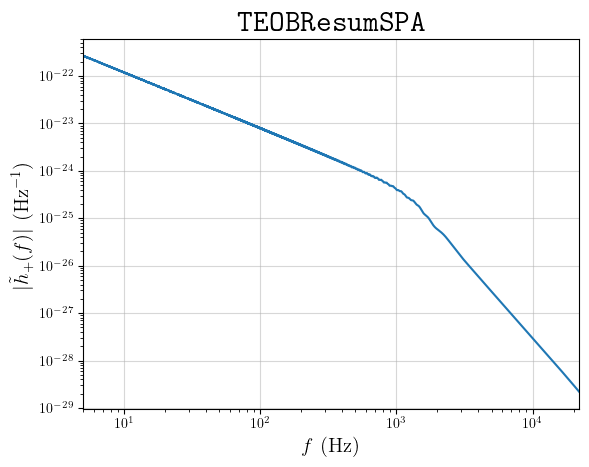

In [14]:
plt.plot(fgrid, AmplHM)

plt.xscale('log')
plt.yscale('log')
plt.xlim(min(fgrid), max(fgrid))
plt.grid(alpha=.5)
plt.xlabel(r'$f\ (\rm Hz)$', fontsize=15)
plt.ylabel(r'$|\tilde{h}_+(f)|\ ({\rm Hz}^{-1})$', fontsize=15)
plt.title(r'$\texttt{TEOBResumSPA}$', fontsize=22)
plt.show()

### FEATURE EXAMPLE: detector relative orientation and distance

#### As an example we verify that the LIGO Hanford and Livingston detectors are rotated by $\sim90^\circ$ and compute their great circle distance

In [15]:
ang = utils.ang_btw_dets_GC(alldetectors['L1'], alldetectors['H1'])
dist = utils.dist_btw_dets_GC(alldetectors['L1'], alldetectors['H1'])
print('The angle between L1 and H1 is %.1f°'%ang)
print('The great circle distance between L1 and H1 is %.1f km'%dist)

The angle between L1 and H1 is 89.9°
The great circle distance between L1 and H1 is 3027.1 km
